In [2]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import glob
import pybedtools as pbt
from ipyparallel import Client
from sklearn import metrics
from itertools import product

plt.style.use('fivethirtyeight')
def clean_axis(ax):
    ax.xaxis.set_tick_params(labelsize=9)
    ax.yaxis.set_tick_params(labelsize=9)
    for i in ['top', 'bottom', 'left', 'right']:
        ax.spines[i].set_visible(False)
    ax.grid(which='major', linestyle='--', alpha=0.5)
    return True

DVIEW = Client()[:]
DVIEW.block=True
len(DVIEW)

30

## The objective here is to demonstrate that Expectation scores predict the G4 structures better than Quadparser and G4Hunter algorithms. For this two approaches will be used.

### First using G4-Seq data, all the genomic regions that either have OQs or do not have OQs (i.e. regions sequenced but did not show only a marginal mismatch rate) were identified. Now using these regions TP, FN, FP, TN were identified using different Expectation value cutoffs. (Will run for approx 2 minutes)

In [117]:
def evaluate_positions_wrapper(chrom, strand):
    import numpy as np
      
    def evaluate_positions(bed_file, strand):
        h = open(bed_file)
        bed_data = h.readlines()
        h.close()
        cutoff_values = [1, 3, 5, 7, 10, 15, 25, 40, 65, 105, 170, 275, 445, 1000]
        pos_vals = [0 for x in cutoff_values]
        neg_vals = [0 for x in cutoff_values]
        for l in bed_data:
            c = l.rstrip('\n').split('\t')
            if c[3] == strand:
                start = int(c[1])
                stop = int(c[2])
                positions_scores = scores[start:stop]
                positions_scores = positions_scores[positions_scores > 1]
                for n,cutoff in enumerate(cutoff_values):
                    a = len(np.where(positions_scores >= cutoff)[0])
                    pos_vals[n] += a
                    neg_vals[n] += len(positions_scores) - a
        return pos_vals, neg_vals

    if strand == "+":
        opp_strand = 'negative'
    elif strand == "-":
        opp_strand = 'positive'
    else:
        raise ValueError("Strand should be either '+' or '-'")

    base_dir = '/home/parashar/scratch/quadcomb/data'
    scores = np.load('%s/sniprq_scores/%s_%s.npy' % 
                     (base_dir, chrom, opp_strand), mmap_mode='r')
    true_p, false_neg = evaluate_positions(
        "%s/ROC_data/regions/chrom_wise/Na_K_2_oq_regions_%s.bed" % (base_dir, chrom),
            strand)
    false_p, true_neg  =  evaluate_positions(
        "%s/ROC_data/regions/chrom_wise/Na_K_2_no_oq_regions_%s.bed" % (base_dir, chrom),
            strand)
    return true_p, false_neg, false_p, true_neg

chroms = ['chr' + str(x) for x in range(1, 23)] + ['chrX', 'chrY']
res = DVIEW.map_sync(evaluate_positions_wrapper, *[chroms*2, (np.repeat(['+', '-'], 24))])

tp, fn, fp, tn = np.array(res).sum(axis=0)
cutoff_values = [1, 3, 5, 7, 10, 15, 25, 40, 65, 105, 170, 275, 445, 1000]
for i in zip(cutoff_values, tp, fn, fp, tn):
    print (i)

sniprq_tpr = tp / (tp + fn)
sniprq_fpr = fp / (fp + tn)
np.save('../data/ROC_data/K2_SNIPRQ_TPR', sniprq_tpr)
np.save('../data/ROC_data/K2_SNIPRQ_FPR', sniprq_fpr)

(1, 12585192, 0, 242859443, 0)
(3, 11977617, 607575, 214300398, 28559045)
(5, 11364784, 1220408, 185855064, 57004379)
(7, 10596652, 1988540, 153335727, 89523716)
(10, 9646883, 2938309, 119165624, 123693819)
(15, 8769051, 3816141, 91947287, 150912156)
(25, 7412612, 5172580, 58182754, 184676689)
(40, 6216632, 6368560, 37978204, 204881239)
(65, 5101828, 7483364, 23417653, 219441790)
(105, 3878936, 8706256, 13464741, 229394702)
(170, 2694869, 9890323, 6731038, 236128405)
(275, 1523199, 11061993, 1612825, 241246618)
(445, 629581, 11955611, 420079, 242439364)
(1000, 24910, 12560282, 1042, 242858401)


### Similarly TP, FN, FP and TN were identified for the Quadparser. Will take around 2.30 min with 30 cores.

In [52]:
def evaluate_motif_positions_wrapper(chrom):
    import pybedtools as pbt

    def evaluate_motif_positions(region_bed_file):
        g4_bed_file = "/home/parashar/scratch/quadruplexes/hg19/g3_%d_%d_%s_nov.bed" % (
            int(loop), int(bulge), chrom)
        fixed_g4_bed = []
        with open(g4_bed_file) as h:
            for l in h:
                c = l.split('\t')
                strand = "+" if c[4][0] == "G" else "C"
                fixed_g4_bed.append("\t".join([
                    c[0], c[1], c[2], '.', '0', strand
                ]))
        g4_bed = pbt.BedTool("\n".join(fixed_g4_bed), from_string=True)

        fixed_region_bed = []
        with open(region_bed_file) as h:
            for l in h:
                c = l.split('\t')
                fixed_region_bed.append("\t".join([
                    c[0], c[1], c[2], '.', '0', c[3]
                ]))
        region_bed = pbt.BedTool("\n".join(fixed_region_bed), from_string=True)
        overlap = region_bed.intersect(g4_bed, S=True, u=True).count()
        return overlap, len(fixed_region_bed) - overlap
    
    res = []
    regions_dir = '/home/parashar/scratch/quadcomb/data/ROC_data/regions/chrom_wise'
    for bulge in [0, 3]:
        for loop in [3, 5, 7, 10, 15, 20, 25, 30, 35, 40, 45, 50]:
            g4_base_dir = '/home/parashar/scratch/quadruplexes/hg19'
            g4_bed_file = "%s/g3_%d_%d_%s_nov.bed" % (g4_base_dir, loop, bulge, chrom)
            base_dir = '/home/parashar/scratch/quadcomb/data'
            true_p, false_neg = evaluate_motif_positions(
                "%s/Na_K_2_oq_regions_%s.bed" % (regions_dir, chrom))
            false_p, true_neg = evaluate_motif_positions(
                "%s/Na_K_2_no_oq_regions_%s.bed" % (regions_dir, chrom))
            res.append([true_p, false_neg, false_p, true_neg])
    return res

chroms = ['chr' + str(x) for x in range(1, 23)] + ['chrX', 'chrY']
res = DVIEW.map_sync(evaluate_motif_positions_wrapper, chroms)

tp, fn, fp, tn = np.array(res).sum(axis=0).T
for i in zip(list(product([0,3], [3, 5, 7, 10, 15, 20, 25, 30, 35, 40, 45, 50])),
             tp, fn, fp, tn):
    print (i)

motif_tpr = tp / (tp + fn)
motif_fpr = fp / (fp + tn)
np.save('../data/ROC_data/K2_MOTIF_TPR', motif_tpr)
np.save('../data/ROC_data/K2_MOTIF_FPR', motif_fpr)

((0, 3), 16020, 1290657, 5396, 9151896)
((0, 5), 36249, 1270428, 28046, 9129246)
((0, 7), 53066, 1253611, 61908, 9095384)
((0, 10), 73908, 1232769, 131909, 9025383)
((0, 15), 98455, 1208222, 271528, 8885764)
((0, 20), 116086, 1190591, 417030, 8740262)
((0, 25), 129945, 1176732, 562617, 8594675)
((0, 30), 141724, 1164953, 702831, 8454461)
((0, 35), 154386, 1152291, 878168, 8279124)
((0, 40), 164818, 1141859, 1009263, 8148029)
((0, 45), 174437, 1132240, 1131289, 8026003)
((0, 50), 185038, 1121639, 1286879, 7870413)
((3, 3), 122126, 1184551, 693101, 8464191)
((3, 5), 156267, 1150410, 1096817, 8060475)
((3, 7), 179203, 1127474, 1437792, 7719500)
((3, 10), 205476, 1101201, 1806382, 7350910)
((3, 15), 246265, 1060412, 2320945, 6836347)
((3, 20), 280563, 1026114, 2686072, 6471220)
((3, 25), 313054, 993623, 2968627, 6188665)
((3, 30), 340632, 966045, 3189921, 5967371)
((3, 35), 367668, 939009, 3396700, 5760592)
((3, 40), 389652, 917025, 3540737, 5616555)
((3, 45), 409297, 897380, 3653168, 5504

### Similarly to identify TP, TN, FP, FN in G4Hunter following steps were taken:

#### First sequences of OQ and No-OQ regions were extracted and then G4Hunter script was run on them

In [94]:
def extract_seq(region_bed_file, fasta_file):
    bed = pbt.BedTool(region_bed_file)
    sequences = []
    data = open(bed.sequence(fi=fasta_file, s=True).seqfn).readlines()
    nuc_map = {'A': 'T', 'G': 'C', 'T': 'A', 'C': 'G', 'N': 'N'}
    for i in range(1, len(data), 2):
        seq = "".join([nuc_map[x] for x in data[i].rstrip('\n').upper()])
        sequences.append(seq)
    with open('data/ROC_data/seq_g4_hunter/%s.seq' % 
              region_bed_file.split('/')[-1].split('.')[0], 'w') as OUT:
        OUT.write("\n".join(sequences))

chroms = ['chr' + str(x) for x in range(1, 23)] + ['chrX', 'chrY']

for chrom in chroms:
    extract_seq(
        "../data/ROC_data/regions/chrom_wise/Na_K_2_oq_regions_%s.bed" % chrom,
        "/home/parashar/scratch/hg19_resource/chromosomes/%s.fa" % chrom
    )
    extract_seq(
        "../data/ROC_data/regions/chrom_wise/Na_K_2_no_oq_regions_%s.bed" % chrom,
        "/home/parashar/scratch/hg19_resource/chromosomes/%s.fa" % chrom
    )

#### TP, FP, FN, TN values were calculated at various cutoffs for G4Hunter scores. Runs in 5 seconds with 30 cores.

In [111]:
def evaluate_hunter_scores_wrapper(chrom):
    import numpy as np

    def evaluate_hunter_scores(fn):
        scores = []
        with open(fn) as handle:
            next(handle)
            for l in handle:
                c = l.rstrip('\n').split('\t')
                scores.append(float(c[1]))
        scores = np.array(scores)
        #scores = scores[scores > 0]
        pos = []
        neg = []
        for i in [-4, -1, -0.2, -0.05, -0.02, -0.01, 0,
                  0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 1.5, 2, 2.5]:
            pos.append(len(np.where(scores >= i)[0]))
            neg.append(len(scores) - pos[-1])
        return pos, neg
    
    base_dir = '/home/parashar/scratch/quadcomb/data/ROC_data/scores_g4_hunter'
    true_p, false_neg = evaluate_hunter_scores(
        "%s/Na_K_2_oq_regions_%s" % (base_dir, chrom))
    false_p, true_neg = evaluate_hunter_scores(
        "%s/Na_K_2_no_oq_regions_%s" % (base_dir, chrom))
    return true_p, false_neg, false_p, true_neg

chroms = ['chr' + str(x) for x in range(1, 23)] + ['chrX', 'chrY']
res = DVIEW.map_sync(evaluate_hunter_scores_wrapper, chroms)
tp, fn, fp, tn = np.array(res).sum(axis=0)
hunter_tpr = tp / (tp + fn)
hunter_fpr = fp / (fp + tn)
np.save('../data/ROC_data/K2_HUNTER_TPR', hunter_tpr)
np.save('../data/ROC_data/K2_HUNTER_FPR', hunter_fpr)

### Now lets load all the TPR and FPR values and make ROC curve for the values

In [118]:
sniprq_tpr = np.load('../data/ROC_data/K2_SNIPRQ_TPR.npy')
sniprq_fpr = np.load('../data/ROC_data/K2_SNIPRQ_FPR.npy')
motif_tpr = np.load('../data/ROC_data/K2_MOTIF_TPR.npy')
motif_fpr = np.load('../data/ROC_data/K2_MOTIF_FPR.npy')
hunter_tpr = np.load('../data/ROC_data/K2_HUNTER_TPR.npy')
hunter_fpr = np.load('../data/ROC_data/K2_HUNTER_FPR.npy')

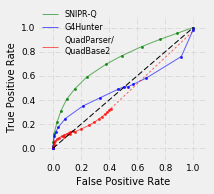

0.722614086258 0.506507432726 0.462103122579


In [121]:
fig, ax = plt.subplots(1, 1, figsize=(3.2,2.8))

ax.plot(sniprq_fpr, sniprq_tpr, lw=1, color='green', alpha=0.6, label='SNIPR-Q')
ax.scatter(sniprq_fpr, sniprq_tpr, s=5, color='green', marker='o', alpha=0.9)

ax.plot(hunter_fpr, hunter_tpr, lw=1, color='blue', alpha=0.6, label='G4Hunter')
ax.scatter(hunter_fpr, hunter_tpr, s=5, color='blue', marker='o', alpha=0.9)

sorted_idx_motif = np.argsort(motif_fpr)
extrapolate_slope = ((motif_tpr[sorted_idx_motif][-7]-motif_tpr[sorted_idx_motif][-1]) /
                     (motif_fpr[sorted_idx_motif][-7]-motif_fpr[sorted_idx_motif][-1]))

ax.plot(motif_fpr[sorted_idx_motif], motif_tpr[sorted_idx_motif],
        lw=1, color='red', alpha=0.6, label='QuadParser/\nQuadBase2')
ax.plot([motif_fpr[sorted_idx_motif][-1], 0.99, 1],
        [motif_tpr[sorted_idx_motif][-1], extrapolate_slope, 1],
        lw=1, color='red', alpha=0.6, ls=':')
ax.scatter(motif_fpr[sorted_idx_motif], motif_tpr[sorted_idx_motif],
           s=5, color='red', marker='o', alpha=0.8)


ax.plot([0,1], [0, 1], lw=1, ls='--', color='k')
clean_axis(ax)
ax.legend(frameon=False, loc=(0, 0.7), fontsize=8, scatterpoints=1)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xlim((-0.1,1.1))
ax.set_ylim((-0.1,1.1))
ax.set_xlabel('False Positive Rate', fontsize=10)
ax.set_ylabel('True Positive Rate', fontsize=10)

plt.tight_layout()
plt.savefig('../images/roc_g4_seq.png', dpi=300, transparent=True, edgecolor='none')
plt.savefig('../images/roc_g4_seq.svg', transparent=True, edgecolor='none')
plt.show()

print (metrics.auc(sniprq_fpr, sniprq_tpr),
       metrics.auc(hunter_fpr, hunter_tpr),
       metrics.auc(list(motif_fpr[sorted_idx_motif])+[1],
                   list(motif_tpr[sorted_idx_motif])+[1]))

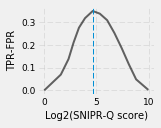

(array([6]),
 array([ 0.34942097]),
 array([ 0.58899475]),
 array([ 0.23957378]),
 array([25]))

In [126]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2))

diff = sniprq_tpr-sniprq_fpr
max_pos = np.where(diff == max(diff))[0]
x = np.array([1, 3, 5, 7, 10, 15, 25, 40, 65, 105, 170, 275, 445, 1000])

ax.plot(np.log2(x), diff, lw=2, color='k', alpha=0.6)
ax.set_xlabel('Log2(SNIPR-Q score)', fontsize=10)
ax.set_ylabel('TPR-FPR', fontsize=10)
ax.axvline(np.log2(x[max_pos]), lw=1, ls='--')
clean_axis(ax)

plt.tight_layout()
plt.savefig('../images/roc_g4_seq_diff_max_val.png', dpi=300, transparent=True, edgecolor='none')
plt.savefig('../images/roc_g4_seq_diff_max_val.svg', transparent=True, edgecolor='none')
plt.show()

max_pos, diff[max_pos], sniprq_tpr[max_pos], sniprq_fpr[max_pos], x[max_pos]